In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
def pairwise_distances(points):
    num_points = len(points)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = np.linalg.norm(points[i] - points[j])

    return dist_matrix

In [12]:
# Load data from CSV file
data = pd.read_csv('krob.csv', sep=' ')
positions = np.array([data['x'], data['y']]).T

def calc_tour_length(cities, tour):
    return sum([cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)])+cities[tour[0]][tour[-1]]

def plot_optimized_tours(positions, cycle1, cycle2, method):
    # Ensure the cycles start and end at the same city to form closed loops
    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    # Plot the optimized tours
    plt.plot(positions[cycle1, 0], positions[cycle1, 1], linestyle='-', marker='o', color='r', label='Cycle 1')
    plt.plot(positions[cycle2, 0], positions[cycle2, 1], linestyle='-', marker='o', color='b', label='Cycle 2')

    # Add legend and title
    plt.legend()
    plt.title('Optimized Tours - '+method)
    plt.show()

## Algorytm Greedy Nearest

Min: 26340.008426699114, Mean: 32324.566144442622, Max: 40265.45008838664


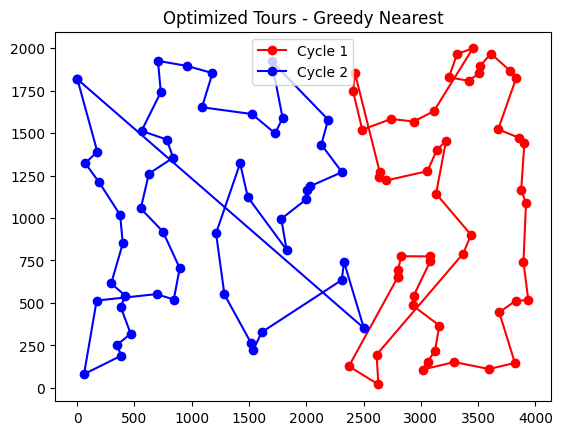

In [13]:
def create_alternate_cycles(cities, start_idx):
    n = cities.shape[0]
    unvisited = list(range(n))
    
    # Randomly choose the starting point for the first cycle
    tour1 = [unvisited.pop(start_idx)]

    # Choose the furthest city from the starting point as the initial point for the second cycle
    start_city_2_idx = np.argmax([cities[tour1[0]][i] for i in unvisited])
    tour2 = [unvisited.pop(start_city_2_idx)]
    

    while unvisited:
        current_city = tour1[-1]

        # Calculate distances to unvisited cities
        distances1 = [cities[current_city][j] for j in unvisited]
        closest_city1 = unvisited.pop(np.argmin(distances1))
        tour1.append(closest_city1)
    
        if unvisited:
            current_city = tour2[-1]

            # Calculate distances to unvisited cities
            distances2 = [cities[current_city][j] for j in unvisited]
            closest_city2 = unvisited.pop(np.argmin(distances2))
            tour2.append(closest_city2)

    return tour1, tour2

# Create two separate cycles without lines crossing
distance_matrix = pairwise_distances(positions)

# cycle1, cycle2 = create_alternate_cycles(distance_matrix)
runs = []
for i in range(100):
    cycle1, cycle2 = create_alternate_cycles(distance_matrix, i)
    l = calc_tour_length(distance_matrix, cycle1) + calc_tour_length(distance_matrix, cycle2)
    runs.append((l, cycle1, cycle2))

l = [r[0] for r in runs]
best = runs[np.argmin(l)]
print(f'Min: {np.min(l)}, Mean: {np.mean(l)}, Max: {np.max(l)}')
cycle1, cycle2 = best[1], best[2]
# Plot the optimized tours
plot_optimized_tours(positions, cycle1, cycle2, 'Greedy Nearest')

## Algorytm Greedy Cycle

Min: 26493.89851237605, Mean: 28612.964175663077, Max: 32083.571137610183


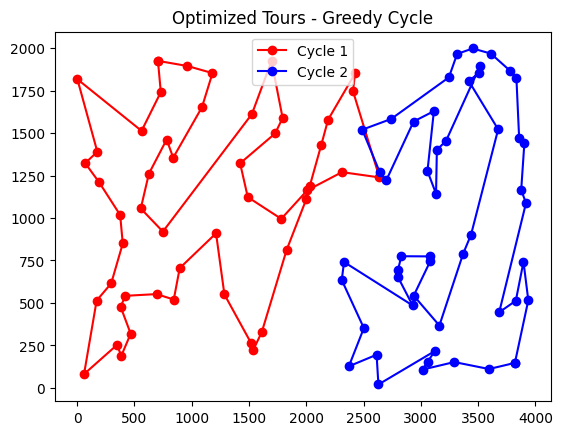

In [14]:
np.random.seed(11)

def create_greedy_cycles(cities, start_idx):
    n = cities.shape[0]
    unvisited = list(range(n))
    
    # Randomly choose the starting point for the first cycle
    tour1 = [unvisited.pop(start_idx)]
    nearest_to_first_1 = [cities[tour1[0]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_first_1)))

    # Choose the furthest city from the starting point as the initial point for the second cycle
    start_city_2_idx = np.argmax([cities[tour1[0]][i] for i in unvisited])
    tour2 = [unvisited.pop(start_city_2_idx)]
    nearest_to_first_2 = [cities[tour2[0]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_first_2)))

    # Add third point to both tours
    nearest_to_tour_1 = [cities[tour1[0]][j] + cities[tour1[1]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_tour_1)))

    nearest_to_tour_2 = [cities[tour2[0]][j] + cities[tour2[1]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_tour_2)))

    # Start adding points that are best fit for the graph
    while unvisited:
        # Find nearest point for every point in the tour, then pick the smallest one
        smallest_value = float('inf')
        best_point = -1
        for tour_point in tour1:
            nearest_points = [cities[tour_point][j] for j in unvisited]
            if min(nearest_points) < smallest_value:
                best_point = np.argmin(nearest_points)
                smallest_value = min(nearest_points)
        best_point = unvisited.pop(best_point)

        # Find all distances between points
        tour_distances = []
        for i in range(len(tour1)):
            if i == len(tour1) - 1:
                tour_distances.append(cities[tour1[-1]][tour1[0]])
            else:
                tour_distances.append(cities[tour1[i]][tour1[i+1]])

        # find smallest increase in distance when adding new point
        best_index = -1
        best_distance = cities[best_point][tour1[0]] + cities[best_point][tour1[-1]] - cities[tour1[0]][tour1[-1]]

        for i in range(len(tour_distances)-1):
            if(cities[best_point][tour1[i]] + cities[best_point][tour1[i+1]] - cities[tour1[i]][tour1[i+1]] < best_distance):
                best_index = i + 1
                best_distance = cities[best_point][tour1[i]] + cities[best_point][tour1[i+1]] - cities[tour1[i]][tour1[i+1]]

        # add new point to the tour with smallest increase in path
        if(best_index == -1):
            tour1.append(best_point)
        else:
            tour1.insert(best_index,best_point)
    
        if unvisited:
            smallest_value = float('inf')
            best_point = -1
            for tour_point in tour2:
                nearest_points = [cities[tour_point][j] for j in unvisited]
                if min(nearest_points) < smallest_value:
                    best_point = np.argmin(nearest_points)
                    smallest_value = min(nearest_points)
            best_point = unvisited.pop(best_point)

            # Find all distances between points
            tour_distances = []
            for i in range(len(tour2)):
                if i == len(tour2) - 1:
                    tour_distances.append(cities[tour2[-1]][tour2[0]])
                else:
                    tour_distances.append(cities[tour2[i]][tour2[i+1]])

            # find smallest increase in distance when adding new point
            best_index = -1
            best_distance = cities[best_point][tour2[0]] + cities[best_point][tour2[-1]] - cities[tour2[0]][tour2[-1]]

            for i in range(len(tour_distances) - 1):
                if(cities[best_point][tour2[i]] + cities[best_point][tour2[i+1]] - tour_distances[i] < best_distance):
                    best_index = i + 1
                    best_distance = cities[best_point][tour2[i]] + cities[best_point][tour2[i+1]] - tour_distances[i]

            # add new point to the tour with smallest increase in path
            if(best_index == -1):
                tour2.append(best_point)
            else:
                tour2.insert(best_index,best_point)

    return tour1, tour2


# Create two separate cycles without lines crossing
distance_matrix = pairwise_distances(positions)

runs = []
for i in range(100):
    cycle1, cycle2 = create_greedy_cycles(distance_matrix, i)
    l = calc_tour_length(distance_matrix, cycle1) + calc_tour_length(distance_matrix, cycle2)
    runs.append((l, cycle1, cycle2))

l = [r[0] for r in runs]
best = runs[np.argmin(l)]
print(f'Min: {np.min(l)}, Mean: {np.mean(l)}, Max: {np.max(l)}')
cycle1, cycle2 = best[1], best[2]
# Plot the optimized tours
plot_optimized_tours(positions, cycle1, cycle2, 'Greedy Cycle')

## Algorytm 2-regret

Best tour with length: 24169.042374758475
Min: 24169.042374758475, Mean: 28533.72672435868, Max: 32250.947034543504


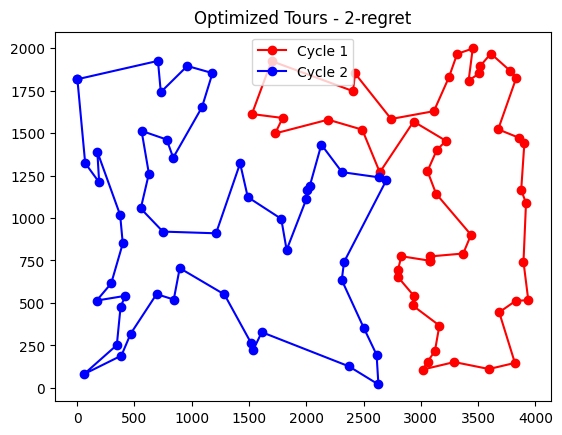

In [15]:
np.random.seed(11)

def calc_tour_length(cities, tour):
    return sum([cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)]) + cities[tour[0]][tour[-1]]

def create_2regret_cycles(cities, start_idx):
    n = cities.shape[0]
    unvisited = list(range(n))
    
    # Choose the starting point for the first cycle
    tour1 = [unvisited.pop(start_idx)]
    nearest_to_first_1 = [cities[tour1[0]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_first_1)))

    # Choose the furthest city from the starting point as the initial point for the second cycle
    start_city_2_idx = np.argmax([cities[tour1[0]][i] for i in unvisited])
    tour2 = [unvisited.pop(start_city_2_idx)]

    nearest_to_first_2 = [cities[tour2[0]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_first_2)))

    # Add third point to both tours
    nearest_to_tour_1 = [cities[tour1[0]][j] + cities[tour1[1]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_tour_1)))

    nearest_to_tour_2 = [cities[tour2[0]][j] + cities[tour2[1]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_tour_2)))

    # Start adding points that are best fit for the graph
    while len(unvisited) > 0:  # Add when the loop ends
        for tour in [tour1, tour2]:
            regrets = []
            for city in unvisited:
                distances = [cities[tour[i]][city] + cities[city][tour[i+1]] - cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)]
                distances.append(cities[tour[0]][city] + cities[city][tour[-1]] - cities[tour[-1]][tour[0]])
                distances.sort()
                regret = distances[1] - distances[0]
                regret -= 0.37 * distances[0]
                regrets.append((regret, city))
            regrets.sort(reverse=True)
            best_city = regrets[0][1]
            tour_distances = [cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)]
            best_increase = float('inf')
            best_index = -1
            for i in range(len(tour_distances)):
                increase = cities[best_city][tour[i]] + cities[best_city][tour[i+1]] - tour_distances[i]
                if increase < best_increase:
                    best_increase = increase
                    best_index = i + 1
            tour.insert(best_index, best_city)
            unvisited.remove(best_city)
    return tour1, tour2


# Create two separate cycles without lines crossing
distance_matrix = pairwise_distances(positions)

runs = []
for i in range(100):
    cycle1, cycle2 = create_2regret_cycles(distance_matrix, i)
    l = calc_tour_length(distance_matrix, cycle1) + calc_tour_length(distance_matrix, cycle2)
    runs.append((l, cycle1, cycle2))

l = [r[0] for r in runs]
best = runs[np.argmin(l)]
print(f'Best tour with length: {best[0]}')
print(f'Min: {np.min(l)}, Mean: {np.mean(l)}, Max: {np.max(l)}')
cycle1, cycle2 = best[1], best[2]

plot_optimized_tours(positions, cycle1, cycle2, '2-regret')